# Chlorophyll-a characteristics of Australian Marine Park

* **Compatability:** Notebook currently compatible with the `NCI` environment
* **Products used:** modis_oc_1d development database
* **Requirements:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set: module use /g/data/v10/public/modules/modulefiles;module load dea
    
* **Prerequisites:** The Introducion_to_MODIS_oceancolor notebook

## Background

The Australian Government has established 60 marine parks around the country. Marine parks help conserve marine habitats and the marine species that live within and rely on these habitats.Marine parks also provide places for people to watch wildlife, dive, and go boating, snorkelling and fishing. Importantly, they create jobs in industries like fishing and tourism, and provide us with food and energy.

Understanding and monitoring the environmental characteristics of Australian marine parks can be challenging due to their remoteness and large sizes. Marine surveys and in-situ observation instrucments can provide environmental information for Australian marine parks. However, they are often very expensive and lack spatial and/or temporal coverages.

### Digitial Earth Australia use case

Imagery from satellites such as [NASA's MODIS](https://terra.nasa.gov/about/terra-instruments/modis) and [NOAA's AVHRR](https://www.ospo.noaa.gov/Operations/POES/NOAA15/avhrr.html) is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring Australian marine parks. 

Satellite data can provide envrionmental information on water quality, sea surface temperature and primary productivity of Australian marine parks in a timely manner. Satellite data can also help detect and monitor harmful events such as algae blooms and marine heat waves occuring in Australian marine parks.

## Description

In this example, we use [IMOS](http://imos.org.au/) MODIS CHL (Chlorophyll-a) data between 2002 and 2019 to characterise the CHL properties of the Cartier Island marine park. The worked example demonstrates how to:

1. Load in MODIS CHL data
2. Create a buffer around the island/reefs to mask out the shallow water
3. Conduct zonal statistics to obtain an overall CHL daily time series
4. Calculate CHL monthly and yearly time series
5. Calculate CHL trends from the time series 
6. Plot the CHL time-series and spatial and temporal variances
7. Identify days of high primary productivity
8. Calculate per-pixel CHL long-term means, seasonal means and monthly means
9. Calculate per-pixel CHL trends
10. Display the spatial distributions of the CHL means with indication of observation frequency
11. Dispaly the spatial distributions of the CHL trends with indication of statistical significance
12. Identify locations of potential primary productivity hotspots

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the \"Load packages\" cell.
    
**After finishing the analysis**, return to the \"Analysis parameters\" cell, modify some values (e.g. choose a different output crs or resolution or a different marine park) and re-run the analysis.

## Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import fiona
import geopandas as gpd
import pandas as pd
import rasterio.features
import numpy as np
import shapefile as shpf
import scipy.ndimage as ndimage
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr

from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
from datacube.utils import geometry
from shapely.geometry import shape, mapping
from rasterstats import zonal_stats
from affine import Affine
from datetime import datetime

## Load MODIS CHL data

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

Note that modis_oc_1d is development product. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

### Analysis parameters
    
The following cell set important parameters for the analysis:
  
* `output_crs`: The original MODIS SST data are in WGS84 coordinate system. If you want to change coordinate system please specify this prameter (e.g., 'EPSG:3577').
* `resoultion`: The desirable spatial resolution of the MODIS CHL data (e.g., '(-1300,1300)').
* `buffer_dist`: The distance (unit=metre) used to buffer the island/reefs to mask out the shallow water.
* `AMP_path`: The polygon shapefile of the Australian marine park
* `reef_path`: The polygon shapefile of the islands/reefs

In [3]:
output_crs = 'EPSG:3577'
resolution = (-1300,1300)
buffer_dist = 2000
AMP_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
reef_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island_island.shp'

### Buffer the island and erase the buffer from the marine park polygon

The erased polygon is used as the geometry to load the MODIS CHL data

In [4]:
##open the polygon
with fiona.open(AMP_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        x = next(iter(shapes))
        first_geometry = next(iter(shapes))['geometry']
        geom1 = geometry.Geometry(first_geometry, crs=crs)

with fiona.open(reef_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom2 = geometry.Geometry(first_geometry, crs=crs)

a = shape(geom1) # the marine park polygon
b = shape(geom2.buffer(buffer_dist)) # buffer the island polygon with a distance of the buffer_dist parameter
newGeom = a.difference(b) # erase the buffer from the marine park polygon
newGeom1 = mapping(newGeom)
newGeom2 = geometry.Geometry(newGeom1, crs=crs) # the newGeom2 geometry is used to load the MODIS data


### Display the outlines of the island (red), the buffer (blue) and the marine park (black)

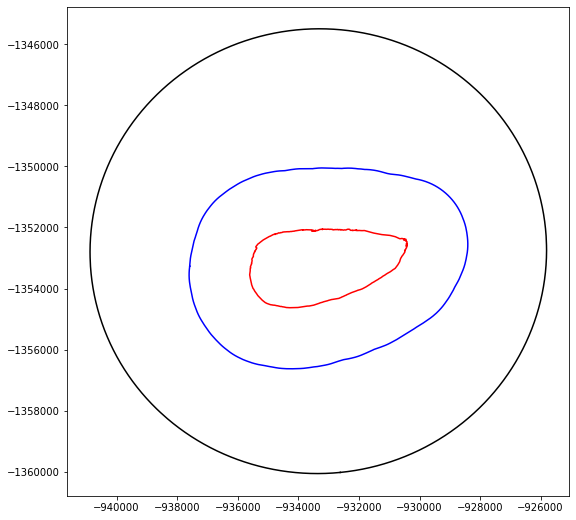

In [5]:
CI = shpf.Reader(AMP_path)
CI_I = shpf.Reader(reef_path)
plt.figure(figsize=(9,9))
# plot the marine park outline
for shape1 in CI.shapeRecords():
    x = [i[0] for i in shape1.shape.points[:]]
    y = [i[1] for i in shape1.shape.points[:]]
    plt.plot(x, y, 'k')
# plot the island outline
for shape1 in CI_I.shapeRecords():
    x = [i[0] for i in shape1.shape.points[:]]
    y = [i[1] for i in shape1.shape.points[:]]
    plt.plot(x, y, 'k',color='red')
# plot the buffer outline
plt.plot(*b.exterior.xy,color='blue')

### Build query and load data

calculate the time taken to load the data

In [6]:
query = {'geopolygon': newGeom2,
         'output_crs': output_crs,
         'resolution': resolution
         }

In [7]:
time1 = datetime.now()
data = dc.load(product='modis_oc_1d', measurements=(['chl_oc3']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:20:14.476220 to finish


### Create a mask for the area covered by the erased marine park polygon
only keep data within the masked area

nodata is also masked

In [8]:
mask = rasterio.features.geometry_mask([newGeom2.to_crs(data.geobox.crs) for geoms in [newGeom2]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
data = data.where(mask)

data = mask_invalid_data(data)

### check the loaded MODIS CHL data

note the time dimension

In [9]:
data

<xarray.Dataset>
Dimensions:  (time: 6214, x: 12, y: 13)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y        (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x        (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    chl_oc3  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

**reset the CHL values > 5.0 mg/m3 to 5.0 mg/m3**

In [10]:
data1 = data.copy(deep=True)
x = data1.chl_oc3
# the chl values greater than 5.0 mg/m3 are likely over-estimated; these values are reset to 5.0 mg/m3
x = x.where((x < 5) | (np.isnan(x)),5)
data1['chl_oc3'] = x

### plot a daily CHL image
A quick check of the loaded data

<Figure size 576x576 with 0 Axes>

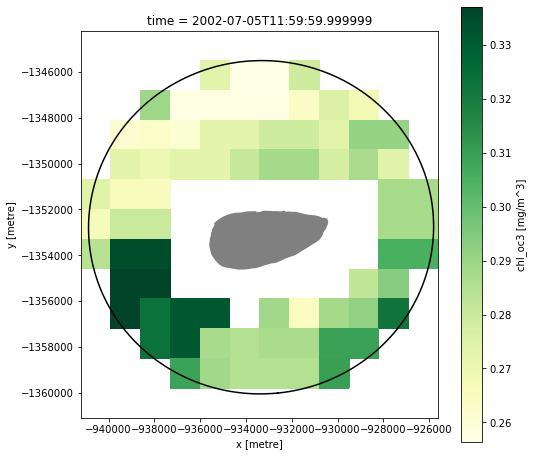

In [11]:
CI = shpf.Reader(AMP_path)
plt.figure(figsize=(8,8))
# plot the island
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(8,8),color='gray')
# plot the marine park outline
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
# plot the CHL image
data1.chl_oc3[1].plot(cmap='YlGn')

### the pad function (written by Eric Oliver) for linear interpolation of missing data in a time series

In [12]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


## conduct zonal statstists

conduct zonal statistics for all CHL data

convert the results to a DataFrame

in doing so, we obtained the daily CHL time-series of the marine park

In [13]:
# use the rasterstats module
i = 0
propertiesList = []
dateList = []
while i < data1['chl_oc3'].time.size:
    date = str(data1['chl_oc3'].time[i].data)[:10]
    dateList.append(date)
    chl = data1.chl_oc3[i].data
    # note the list of the statistical parameters to be calculated
    stats = zonal_stats(AMP_path,chl,affine=data1.affine,stats=['min','max','mean','range','median','std','sum','count'],geojson_out=True)
    
    propertiesList.append(stats[0]['properties'])    
    
    i = i + 1
chlWDF = pd.DataFrame(propertiesList)
chlWDF['date']=dateList
chlWDF.set_index('date',inplace=True)

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


**check that the dataframe of the time-series looks OK**

In [14]:
chlWDF.head(10)

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,range
date,,,,,,,,,,,
2002-07-04,Cartier Island,North-west,172.374499,74,0.219028,0.437202,0.282316,20.891404,0.036252,0.275236,0.218174
2002-07-05,Cartier Island,North-west,172.374499,74,0.256408,0.337014,0.287571,21.280237,0.022430,0.284785,0.080605
2002-07-06,Cartier Island,North-west,172.374499,74,0.272551,0.444321,0.386405,28.593986,0.039322,0.390818,0.171770
2002-07-07,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-07-08,Cartier Island,North-west,172.374499,74,0.237713,0.430212,0.348677,25.802093,0.048085,0.356008,0.192499
2002-07-09,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-07-10,Cartier Island,North-west,172.374499,74,0.221449,0.345159,0.270167,19.992370,0.032220,0.264350,0.123709
2002-07-11,Cartier Island,North-west,172.374499,74,0.193791,0.644601,0.279946,20.716009,0.064434,0.273454,0.450810
2002-07-12,Cartier Island,North-west,172.374499,74,0.234910,0.349412,0.286104,21.171732,0.032311,0.276715,0.114502


**plot the daily mean CHL time series for the AMP**

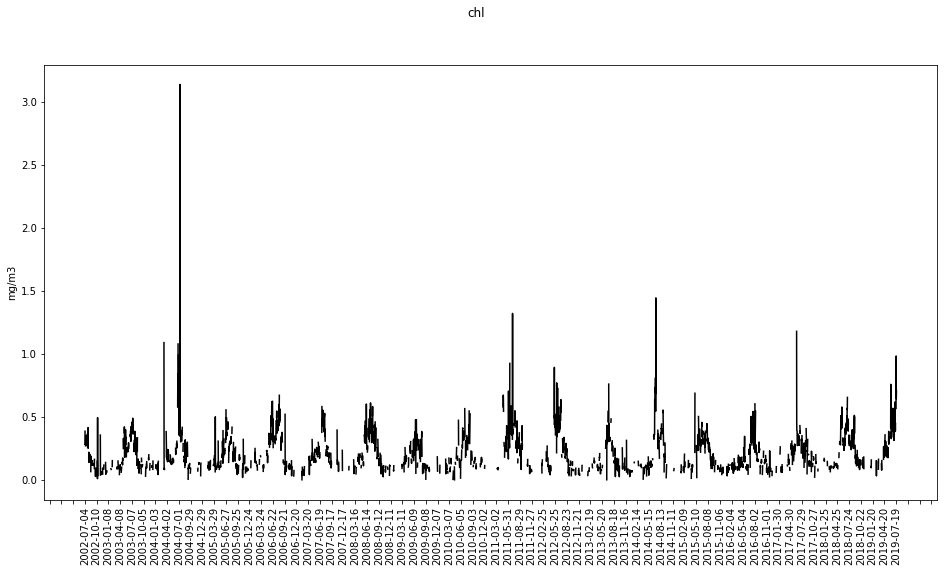

In [15]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(chlWDF.index.values,chlWDF['mean'].values,color='black')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('mg/m3')
fig.suptitle('chl')

plt.show()

**apply interpolation on the daily mean, min and max CHL time-series**

In [16]:
meanI = pad(chlWDF['mean'].values,maxPadLength=False)
minI = pad(chlWDF['min'].values,maxPadLength=False)
maxI = pad(chlWDF['max'].values,maxPadLength=False)
chlWDF['meanI'] = meanI
chlWDF['minI'] = minI
chlWDF['maxI'] = maxI

**plot the interploated daily CHL mean, minimum and maximum time-series**

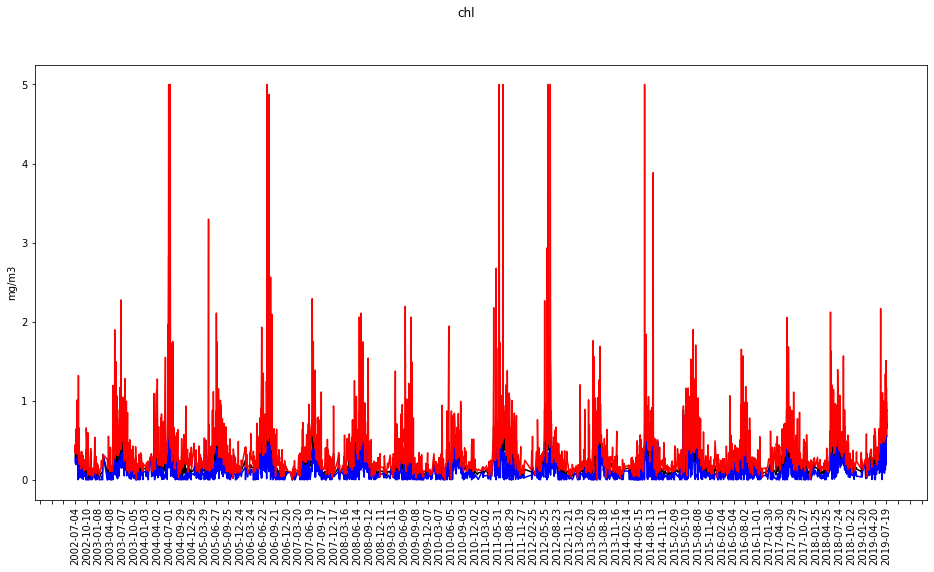

In [17]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(chlWDF.index.values,chlWDF['meanI'].values,color='black')
ax.plot(chlWDF.index.values,chlWDF['minI'].values,color='blue')
ax.plot(chlWDF.index.values,chlWDF['maxI'].values,color='red')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('mg/m3')
fig.suptitle('chl')

plt.show()

## Calculate CHL monthly, seaonal and yearly time-series, and annual trends


**add year, month, season and yearmonth column**

In [18]:
yearList = []
monthList = []
seasonList = []
yearmonthList = []
for date in chlWDF.index:
    year = date[:4]
    month = date[5:7]
    if month in ['12','01','02']:
        season = 'summer'
    elif month in ['03','04','05']:
        season = 'autumn'
    elif month in ['06','07','08']:
        season = 'winter'
    else:
        season = 'spring'
    yearList.append(year)
    monthList.append(month)
    seasonList.append(season)
    yearmonth = year+month
    yearmonthList.append(yearmonth)
chlWDF['year'] = yearList
chlWDF['month'] = monthList
chlWDF['season'] = seasonList
chlWDF['yearmonth'] = yearmonthList

**group by year and yearmonth to generate the yearly (annual) and monthly time-series**

In [19]:
x = chlWDF['mean'].groupby(chlWDF['year'])
yearmeanchlWDF = x.describe()
x = chlWDF['min'].groupby(chlWDF['year'])
yearminchlWDF = x.describe()
x = chlWDF['max'].groupby(chlWDF['year'])
yearmaxchlWDF = x.describe()
x = chlWDF['std'].groupby(chlWDF['year'])
yearstdchlWDF = x.describe()

x = chlWDF['mean'].groupby(chlWDF['yearmonth'])
yearmonthmeanchlWDF = x.describe()
x = chlWDF['std'].groupby(chlWDF['yearmonth'])
yearmonthstdchlWDF = x.describe()

**year 2002 and 2019 are partial years and should not be included**

In [20]:
yearmeanchlWDF1 = yearmeanchlWDF.loc['2003':'2018']
yearminchlWDF1 = yearminchlWDF.loc['2003':'2018']
yearmaxchlWDF1 = yearmaxchlWDF.loc['2003':'2018']
yearstdchlWDF1 = yearstdchlWDF.loc['2003':'2018']

yearmonthmeanchlWDF1 = yearmonthmeanchlWDF.loc['200301':'201812']
yearmonthstdchlWDF1 = yearmonthstdchlWDF.loc['200301':'201812']

**group by month to calculate monthly statistics**

In [21]:
x = chlWDF['meanI'].groupby(chlWDF['month'])
monthmeanIchlWDF = x.describe()
x = chlWDF['mean'].groupby(chlWDF['month'])
monthmeanchlWDF = x.describe()
x = chlWDF['std'].groupby(chlWDF['month'])
monthstdchlWDF = x.describe()

**fit a linear trend line to the interpolated daily mean CHL time-series**

**the slope indicates the daily trend**

                            OLS Regression Results                            
Dep. Variable:                  meanI   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.169
Date:                Thu, 09 Apr 2020   Prob (F-statistic):             0.0130
Time:                        11:14:05   Log-Likelihood:                 3288.0
No. Observations:                6214   AIC:                            -6572.
Df Residuals:                    6212   BIC:                            -6559.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1774      0.004     49.024      0.0

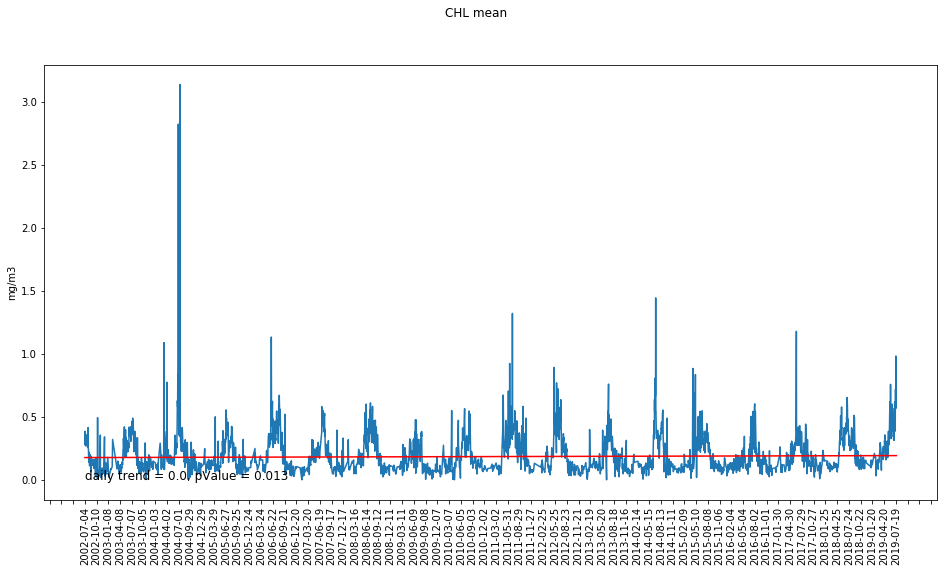

In [22]:
# use the seaborn and statsmodels modules
ind = np.arange(1,chlWDF['meanI'].size+1,1)
chlWDF['ind'] = ind

meanFit = sm.ols(formula='meanI ~ ind', data=chlWDF).fit()
print(meanFit.summary())

predict = meanFit.predict(chlWDF)
chlWDF['mean_fitted'] = predict

# obtain the trend (slope of the trend line) and pValue (indication of the statistical significance)
rate = round(meanFit.params[1],4)
pValue = round(meanFit.pvalues[1],4)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = chlWDF.index[0]
textY = chlWDF['meanI'].min()
plt.text(textX,textY,"daily trend = " + str(rate) + ", pValue = " + str(pValue),fontsize=12)
ax.plot(chlWDF.index.values,chlWDF['meanI'].values)

ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.plot(chlWDF.ind, chlWDF.mean_fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL mean')

plt.show()



**plot and fit a linear trend line to the annual mean time-series**

**the trend is the annual trend**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                   0.08847
Date:                Thu, 09 Apr 2020   Prob (F-statistic):              0.770
Time:                        11:14:09   Log-Likelihood:                 32.463
No. Observations:                  16   AIC:                            -60.93
Df Residuals:                      14   BIC:                            -59.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2157      0.018     12.093      0.0

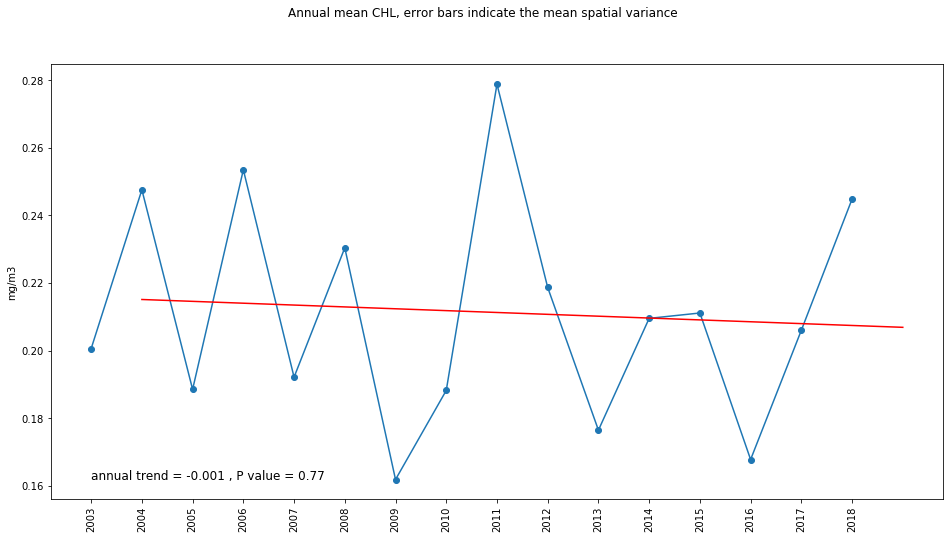

In [23]:
ind = np.arange(1,yearmeanchlWDF1['mean'].size+1,1)
yearmeanchlWDF1['ind'] = ind

yearmeanFit = sm.ols(formula='mean ~ ind', data=yearmeanchlWDF1).fit()
print(yearmeanFit.summary())

predict = yearmeanFit.predict(yearmeanchlWDF1)
yearmeanchlWDF1['fitted'] = predict

rate = round(yearmeanFit.params[1],3)
pValue = round(yearmeanFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmeanchlWDF1.index[0]
textY = yearmeanchlWDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,marker='o')

ax.plot(yearmeanchlWDF1.ind, yearmeanchlWDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('Annual mean CHL, error bars indicate the mean spatial variance')

plt.show()

**plot annual mean CHL time-series, and its temporal variance and mean spatial variance as error bars**

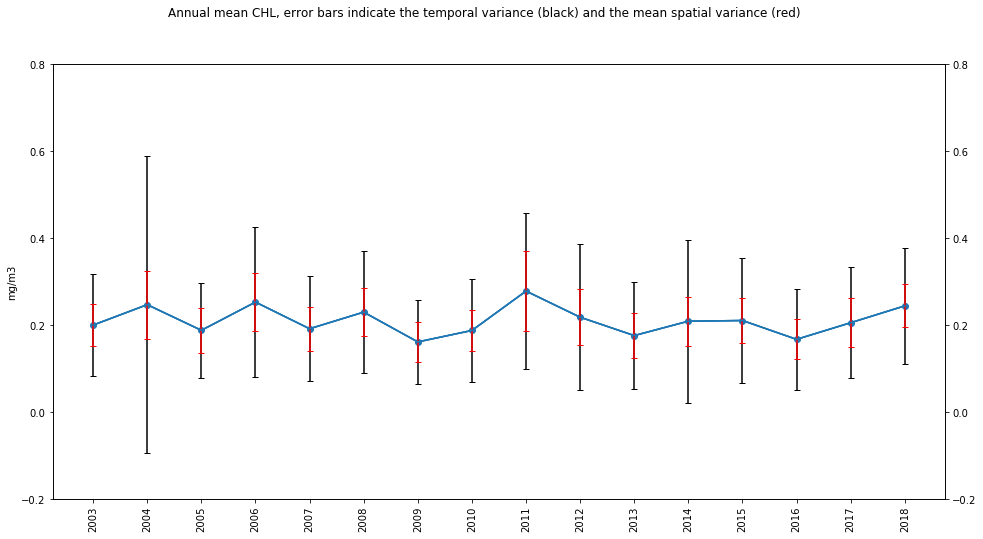

In [24]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')


ax1.plot(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,marker='o')
ax1.errorbar(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,yerr=yearmeanchlWDF1['std'].values,ecolor="black",
           capsize=3.0)

ax1.set_ylabel('mg/m3')
ax1.set_ylim(ymin=-0.2,ymax=0.8)
ax2 = ax1.twinx()
ax2.errorbar(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,yerr=yearstdchlWDF1['mean'].values,ecolor="red",
           capsize=3.0)
ax2.set_ylim(ymin=-0.2,ymax=0.8)
fig.suptitle('Annual mean CHL, error bars indicate the temporal variance (black) and the mean spatial variance (red)')

plt.show()

**plot the variation of the monthly means, and their temporal and spatial variances as error bars**

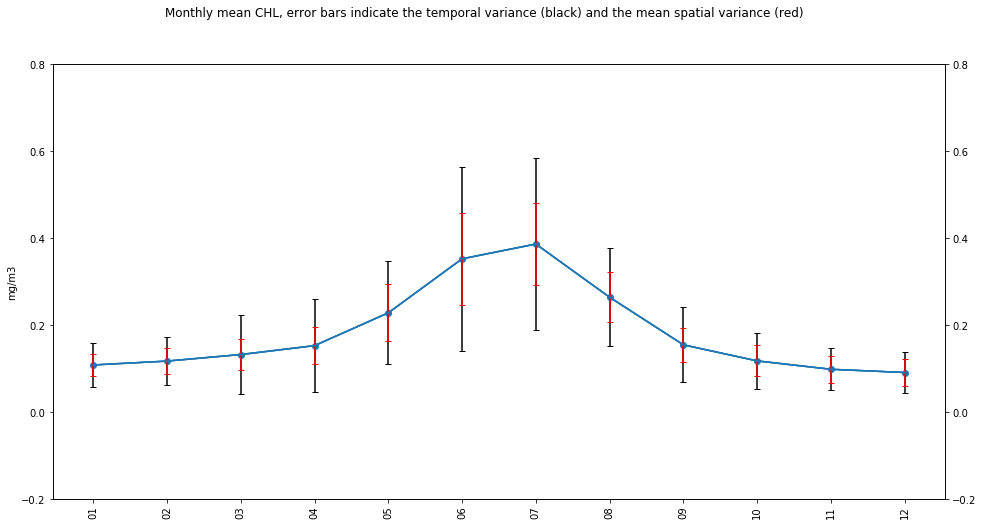

In [25]:
fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')
ax1.plot(monthmeanchlWDF.index.values,monthmeanchlWDF['mean'].values,marker='o')
ax1.errorbar(monthmeanchlWDF.index.values,monthmeanchlWDF['mean'].values,yerr=monthmeanchlWDF['std'].values,ecolor="black",capsize=3.0)
ax1.set_ylabel('mg/m3')
ax1.set_ylim(ymin=-0.2,ymax=0.8)
ax2 = ax1.twinx()
ax2.errorbar(monthmeanchlWDF.index.values,monthmeanchlWDF['mean'].values,yerr=monthstdchlWDF['mean'].values,ecolor="red",capsize=3.0)
ax2.set_ylim(ymin=-0.2,ymax=0.8)
fig.suptitle('Monthly mean CHL, error bars indicate the temporal variance (black) and the mean spatial variance (red)')

plt.show()

**calculate annual time-series of seasonal statistics (mean, std, etc) using the interpolated data**

In [26]:
# note how to deal with multiindex
meanIDF = chlWDF[['meanI','year','season']]
x = meanIDF.groupby(['year','season'])
yearseasonmeanIchlWDF = x.describe()

idx = pd.IndexSlice
SummermeanIchlWDF = yearseasonmeanIchlWDF.loc[idx[:,['summer']],:]
AutumnmeanIchlWDF = yearseasonmeanIchlWDF.loc[idx[:,['autumn']],:]
WintermeanIchlWDF = yearseasonmeanIchlWDF.loc[idx[:,['winter']],:]
SpringmeanIchlWDF = yearseasonmeanIchlWDF.loc[idx[:,['spring']],:]

SummermeanIchlWDF.reset_index(inplace=True)
SummermeanIchlWDF.set_index('year',inplace=True)
x = SummermeanIchlWDF.columns.droplevel(level=0)
SummermeanIchlWDF.columns=x
AutumnmeanIchlWDF.reset_index(inplace=True)
AutumnmeanIchlWDF.set_index('year',inplace=True)
x = AutumnmeanIchlWDF.columns.droplevel(level=0)
AutumnmeanIchlWDF.columns=x
WintermeanIchlWDF.reset_index(inplace=True)
WintermeanIchlWDF.set_index('year',inplace=True)
x = WintermeanIchlWDF.columns.droplevel(level=0)
WintermeanIchlWDF.columns=x
SpringmeanIchlWDF.reset_index(inplace=True)
SpringmeanIchlWDF.set_index('year',inplace=True)
x = SpringmeanIchlWDF.columns.droplevel(level=0)
SpringmeanIchlWDF.columns=x

# the summer seasons (Jan, Feb and Dec) in 2002 and 2019 are not complete and should be exclued
SummermeanIchlWDF1 = SummermeanIchlWDF.loc['2003':'2018']
# the winter seasons (Jun, July and Aug) in 2002 and 2019 are not complete and should be exclued
WintermeanIchlWDF1 = WintermeanIchlWDF.loc['2003':'2018']

**plot and fit a linear trend line for the annual time-series of seasonal mean (Spring in this case)**

**the trend is the annual trend for the season**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     2.481
Date:                Thu, 09 Apr 2020   Prob (F-statistic):              0.136
Time:                        11:14:11   Log-Likelihood:                 38.317
No. Observations:                  17   AIC:                            -72.63
Df Residuals:                      15   BIC:                            -70.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1034      0.014      7.537      0.0

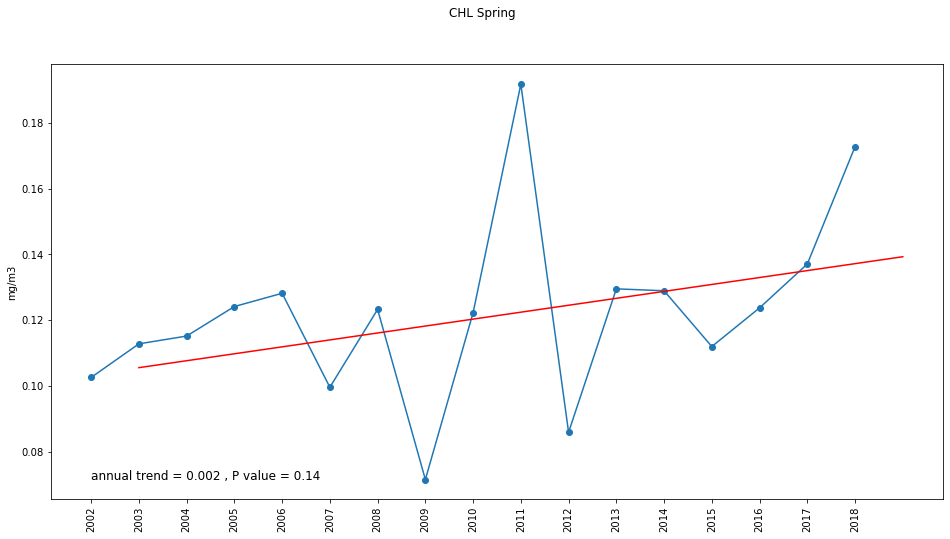

In [27]:
ind = np.arange(1,SpringmeanIchlWDF['mean'].size+1,1)
SpringmeanIchlWDF['ind'] = ind

SpringmeanIFit = sm.ols(formula='mean ~ ind', data=SpringmeanIchlWDF).fit()
print(SpringmeanIFit.summary())

predict = SpringmeanIFit.predict(SpringmeanIchlWDF)
SpringmeanIchlWDF['fitted'] = predict

rate = round(SpringmeanIFit.params[1],3)
pValue = round(SpringmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = SpringmeanIchlWDF.index[0]
textY = SpringmeanIchlWDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(SpringmeanIchlWDF.index.values,SpringmeanIchlWDF['mean'].values,marker='o')


ax.plot(SpringmeanIchlWDF.ind, SpringmeanIchlWDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Spring')

plt.show()

## identify high primary productivity days

A high primary productivity day is defined as a day with a mean CHL value greater than the 95% percentile of the whole time-series (all days in all years)

In [28]:
productivedaysDF = pd.DataFrame()
productivedaysList = []
yearList = chlWDF.year.unique() # get unique values in a column
p95 = chlWDF['meanI'].quantile(0.95) # get 95% percentile of the entire time-series
for year in yearList:    
    tempDF = chlWDF[chlWDF['year'] == year]
    
    productivedays = (tempDF['meanI'] > p95).sum()
   
    productivedaysList.append(productivedays)
productivedaysDF['year'] = yearList
productivedaysDF['productivedays'] = productivedaysList
productivedaysDF.set_index('year',inplace=True)

productivedaysDF1 = productivedaysDF.loc['2003':'2018']

**plot and fit a linear trend line to the annual time-series of number of high primary productivity days**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


                            OLS Regression Results                            
Dep. Variable:         productivedays   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                   0.08040
Date:                Thu, 09 Apr 2020   Prob (F-statistic):              0.781
Time:                        11:14:11   Log-Likelihood:                -58.078
No. Observations:                  16   AIC:                             120.2
Df Residuals:                      14   BIC:                             121.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.6500      5.115      3.646      0.0

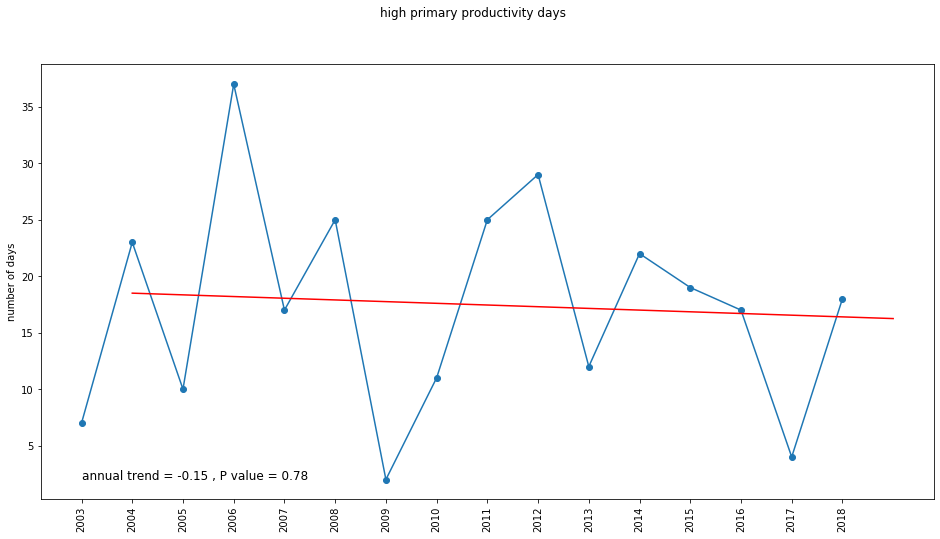

In [29]:
ind = np.arange(1,productivedaysDF1.index.size+1,1)
productivedaysDF1['ind'] = ind

productivedaysIFit = sm.ols(formula='productivedays ~ ind', data=productivedaysDF1).fit()
print(productivedaysIFit.summary())

predict = productivedaysIFit.predict(productivedaysDF1)
productivedaysDF1['fitted'] = predict

rate = round(productivedaysIFit.params[1],3)
pValue = round(productivedaysIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = productivedaysDF1.index[0]
textY = productivedaysDF1['productivedays'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(productivedaysDF1.index.values,productivedaysDF1['productivedays'].values,marker='o')


ax.plot(productivedaysDF1.ind, productivedaysDF1.fitted, 'r')
ax.set_ylabel('number of days')
fig.suptitle('high primary productivity days')

plt.show()

## Calculate per-pixel CHL long-term means, seasonal means, monthly means and trends

### create a dataframe to contain all per-pixel CHL data loaded
156 (12 x 13) locations (as columns) with 6214 daily time-series (as rows)

**latlonDF contains the X, Y coordinates of the locations**

In [30]:
chlDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < data1.y.size:
    while lonIndex < data1.x.size:
        lat = data1.chl_oc3[:,latIndex,lonIndex].y.values
        lon = data1.chl_oc3[:,latIndex,lonIndex].x.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(str(id))
        chlData = data1.chl_oc3[:,latIndex,lonIndex].values
        chlDF[str(id)] = chlData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0
dateList = []
i = 0
while i < data1.time.size:
    date = str(data1.time[i].data)[:4] + str(data1.time[i].data)[5:7] + str(data1.time[i].data)[8:10]
    dateList.append(date)
    i += 1
chlDF['date'] = dateList
chlDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList
latlonDF.set_index('id', inplace=True)

### calculate per-pixel annual mean CHL values

**add year column to the dataframe**

In [31]:
yearList = []
for date in chlDF.index:
    year = date[:4]
    yearList.append(year)
chlDF['year'] = yearList

**The yearCHLDF contains time-series of annual mean CHL values for pixels that have at least some valid data**

In [32]:
yearCHLDF = pd.DataFrame()
for col in chlDF.columns:    
    if col.isdigit():
        # number of days with valid data (observation); each column is a pixel
        nuData = chlDF.index.size - np.isnan(chlDF[col]).sum()
        if nuData > 0:            
            x = chlDF[col].groupby(chlDF['year']) # groupby year
            xDF = x.describe() # a DataFrame containing the results of the groupby operation
            yearCHLDF[col] = xDF['mean'] # only interest in the mean statistic

        

**years 2002 and 2019 are partial years and should be excluded for time-series analyses**

In [33]:
yearCHLDF1 = yearCHLDF.loc['2003':'2018']

### Calculate and display per-pixel annual trends

**The yearRateDF contains, for each pixel with some valid data, the fitted CHL annual trend rate, the number of days with data and the observation frequency within the time-series of the annual mean. A low observation frequency indicates high uncertainty of the fitted trend.**

In [34]:
ind = np.arange(1,yearCHLDF1.index.size+1,1)
yearCHLDF1['ind'] = ind
yearRateDF = pd.DataFrame()
idList = []
rateList = []
pValueList = []
for col in yearCHLDF1.columns:
    if col.isdigit():
        idList.append(col)
        # note the Q() function for the proper handling of the number as a column name
        formula = 'Q("' + col + '")' + ' ~ ind'
        
        fit = sm.ols(formula=formula, data=yearCHLDF1).fit()

        predict = fit.predict(yearCHLDF1)
        yearCHLDF1['fitted'] = predict
        rate = round(fit.params[1],3)
        pValue = round(fit.pvalues[1],2)
        
        rateList.append(rate)
        pValueList.append(pValue)
yearRateDF['id'] = idList
yearRateDF['rate'] = rateList
yearRateDF['pValue'] = pValueList

countList = []
freqList = []
for col in chlDF.columns:
    if col.isdigit():        
        x = chlDF.index.size - np.isnan(chlDF[col]).sum()
        if x > 0:            
            f = x/chlDF.index.size
            countList.append(x)
            freqList.append(f)
yearRateDF['count'] = countList
yearRateDF['frequency'] = freqList
yearRateDF.set_index("id",inplace=True)

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


**add the x and y columns to the yearRateDF**

In [35]:
xList = []
yList = []
for id in yearRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearRateDF['x'] = xList
yearRateDF['y'] = yList

In [36]:
yearRateDF

,rate,pValue,count,frequency,x,y
id,,,,,,
17,0.000,0.97,2165,0.348407,-935350,-1346150
18,0.000,0.99,2171,0.349372,-934050,-1346150
19,-0.000,0.86,2172,0.349533,-932750,-1346150
20,-0.001,0.55,2186,0.351786,-931450,-1346150
27,0.001,0.64,2152,0.346315,-937950,-1347450
...,...,...,...,...,...,...
137,0.000,0.92,2162,0.347924,-935350,-1359150
138,0.001,0.65,2148,0.345671,-934050,-1359150
139,0.000,0.95,2154,0.346637,-932750,-1359150


**convert the yearRateDF to an xarray dataset**

In [37]:
import xarray as xr
yearRateDF1 = yearRateDF.copy()
yearRateDF1.set_index(['y','x'],inplace=True)
yearRateData = xr.Dataset.from_dataframe(yearRateDF1)
yearRateData.attrs['crs']='EPSG:3577'

**display the spatial distribution of the annual trend rates; the black dots indicate that the pixels have statitically significant warming rates at 90% confidence level**

<Figure size 864x576 with 0 Axes>

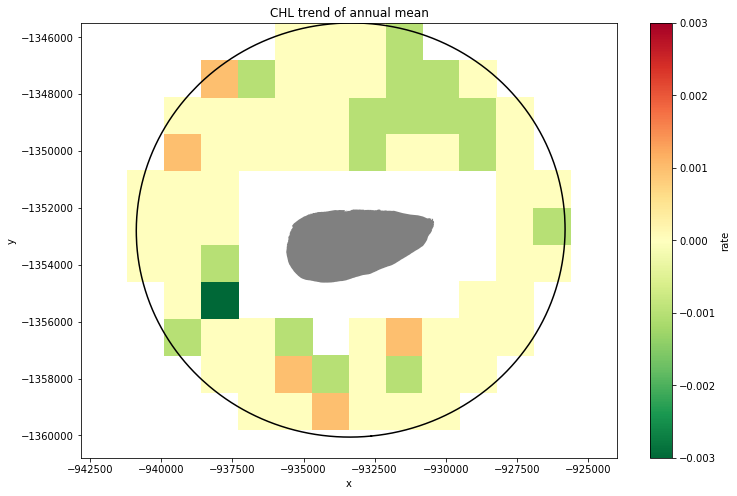

In [38]:
CI = shpf.Reader(AMP_path)
minV = yearRateData['rate'].min()
maxV = yearRateData['rate'].max()

if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)
    
plt.figure(figsize=(12,8))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(12,8),color='gray')

yearRateData['rate'].plot(cmap=colormap,vmin=minV,vmax=maxV)
plt.title('CHL trend of annual mean')
plt.axis('equal')
# only highlight data points where pValue <= 0.1, representing significance level >= 90%
tempDF = yearRateDF[yearRateDF['pValue'] <= 0.10]
x = tempDF['x']
y = tempDF['y']

plt.scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


### Calulate and display per-pixel long-term CHL means

**The overallDF contains the long-term mean (std) CHL values for each pixels with some valid data**

In [39]:
overallDF = pd.DataFrame()
meanList = []
stdList = []
countList = []
freqList = []
idList = []
for col in chlDF.columns:
    if col.isdigit():        
        x = chlDF.index.size - np.isnan(chlDF[col]).sum()
        if x > 0:        
            chlMean = chlDF[col].mean()
            chlStd = chlDF[col].std()
            f = x/chlDF.index.size
            meanList.append(chlMean)
            stdList.append(chlStd)
            countList.append(x)
            freqList.append(f)
            idList.append(col)
overallDF['id'] = idList
overallDF['mean'] = meanList
overallDF['std'] = stdList
overallDF['count'] = countList
overallDF['frequency'] = freqList
overallDF.set_index('id', inplace=True)

xList = []
yList = []
for id in overallDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
overallDF['x'] = xList
overallDF['y'] = yList

**convert the dataframe to an xarray daaset**

In [40]:
overallDF1 = overallDF.copy()
overallDF1.set_index(['y','x'],inplace=True)
overallData = xr.Dataset.from_dataframe(overallDF1)
overallData.attrs['crs']='EPSG:3577'

**plot the spatial distribution of the CHL long-term mean; the black dots indicate that the pixels have observation frequency > 30% of the time-series**

<Figure size 864x576 with 0 Axes>

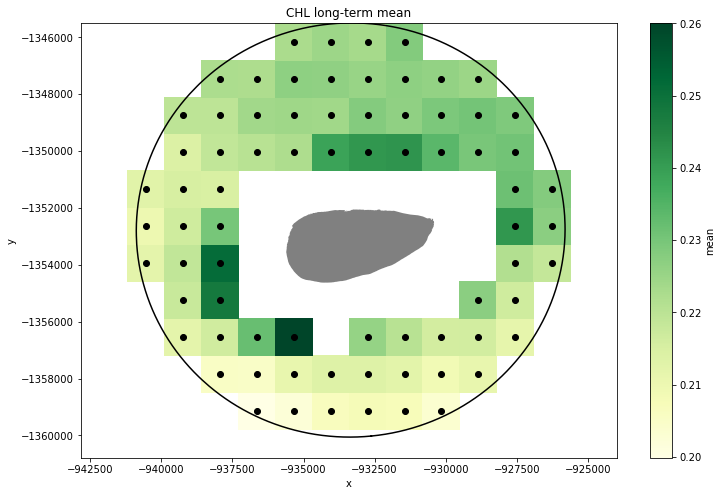

In [41]:

CI = shpf.Reader(AMP_path)
fig = plt.figure(figsize=(12,8))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(12,8),color='gray')

overallData['mean'].plot(cmap='YlGn')
plt.axis('equal')
plt.title('CHL long-term mean')
tempDF = overallDF[overallDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

plt.scatter(x,y,c='black')
for shape in CI.shapeRecords():

    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


### Calculate and display per-pixel seasonal and monthly CHL means

**add season and month columns**

In [42]:
seasonList = []
monthList = []
for date in chlDF.index:
    month = date[4:6]
    monthList.append(month)
    if month in ['12','01','02']:
        season = 'summer'
    elif month in ['03','04','05']:
        season = 'autumn'
    elif month in ['06','07','08']:
        season = 'winter'
    else:
        season = 'spring'
    seasonList.append(season)
chlDF['season'] = seasonList
chlDF['month'] = monthList

**seasonal statistics (e.g., mean, std, etc) for each pixels**

In [43]:
winterCHLDF = pd.DataFrame()
springCHLDF = pd.DataFrame()
summerCHLDF = pd.DataFrame()
autumnCHLDF = pd.DataFrame()
wi_meanList = []
wi_stdList = []
wi_countList = []
wi_freqList = []
sp_meanList = []
sp_stdList = []
sp_countList = []
sp_freqList = []
su_meanList = []
su_stdList = []
su_countList = []
su_freqList = []
au_meanList = []
au_stdList = []
au_countList = []
au_freqList = []

idList = []
for col in chlDF.columns:    
    if col.isdigit():             
        nuData = chlDF.index.size - np.isnan(chlDF[col]).sum()
        if nuData > 0:            
            x = chlDF[col].groupby(chlDF['season']) # groupby season
            xDF = x.describe() # a DataFrame containing the results of the groupby operation
            wi_mean = xDF.loc['winter']['mean']
            wi_std = xDF.loc['winter']['std']
            wi_count = xDF.loc['winter']['count']
            wi_freq = xDF.loc['winter']['count'] / (chlDF['season']=='winter').sum()
            
            sp_mean = xDF.loc['spring']['mean']
            sp_std = xDF.loc['spring']['std']
            sp_count = xDF.loc['spring']['count']
            sp_freq = xDF.loc['spring']['count'] / (chlDF['season']=='spring').sum()
            
            su_mean = xDF.loc['summer']['mean']
            su_std = xDF.loc['summer']['std']
            su_count = xDF.loc['summer']['count']
            su_freq = xDF.loc['summer']['count'] / (chlDF['season']=='summer').sum()
            
            au_mean = xDF.loc['autumn']['mean']
            au_std = xDF.loc['autumn']['std']
            au_count = xDF.loc['autumn']['count']
            au_freq = xDF.loc['autumn']['count'] / (chlDF['season']=='autumn').sum()
            
            idList.append(col)
            
            wi_meanList.append(wi_mean)
            wi_stdList.append(wi_std)
            wi_countList.append(wi_count)
            wi_freqList.append(wi_freq)
            
            sp_meanList.append(sp_mean)
            sp_stdList.append(sp_std)
            sp_countList.append(sp_count)
            sp_freqList.append(sp_freq)
            
            su_meanList.append(su_mean)
            su_stdList.append(su_std)
            su_countList.append(su_count)
            su_freqList.append(su_freq)
            
            au_meanList.append(au_mean)
            au_stdList.append(au_std)
            au_countList.append(au_count)
            au_freqList.append(au_freq)
            
winterCHLDF['id'] = idList
winterCHLDF['mean'] = wi_meanList
winterCHLDF['std'] = wi_stdList
winterCHLDF['count'] = wi_countList
winterCHLDF['frequency'] = wi_freqList
winterCHLDF.set_index('id',inplace=True)

springCHLDF['id'] = idList
springCHLDF['mean'] = sp_meanList
springCHLDF['std'] = sp_stdList
springCHLDF['count'] = sp_countList
springCHLDF['frequency'] = sp_freqList
springCHLDF.set_index('id',inplace=True)

summerCHLDF['id'] = idList
summerCHLDF['mean'] = su_meanList
summerCHLDF['std'] = su_stdList
summerCHLDF['count'] = su_countList
summerCHLDF['frequency'] = su_freqList
summerCHLDF.set_index('id',inplace=True)

autumnCHLDF['id'] = idList
autumnCHLDF['mean'] = au_meanList
autumnCHLDF['std'] = au_stdList
autumnCHLDF['count'] = au_countList
autumnCHLDF['frequency'] = au_freqList
autumnCHLDF.set_index('id',inplace=True)
        

**add x and y to the seasonal dataframes**

In [44]:
xList = []
yList = []
for id in winterCHLDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
winterCHLDF['x'] = xList
winterCHLDF['y'] = yList

springCHLDF['x'] = xList
springCHLDF['y'] = yList

summerCHLDF['x'] = xList
summerCHLDF['y'] = yList

autumnCHLDF['x'] = xList
autumnCHLDF['y'] = yList

**convert dataframes to xarry datasets**

In [45]:
winterCHLDF1 = winterCHLDF.copy()
winterCHLDF1.set_index(['y','x'],inplace=True)
winterCHLData = xr.Dataset.from_dataframe(winterCHLDF1)
winterCHLData.attrs['crs']='EPSG:3577'

springCHLDF1 = springCHLDF.copy()
springCHLDF1.set_index(['y','x'],inplace=True)
springCHLData = xr.Dataset.from_dataframe(springCHLDF1)
springCHLData.attrs['crs']='EPSG:3577'

summerCHLDF1 = summerCHLDF.copy()
summerCHLDF1.set_index(['y','x'],inplace=True)
summerCHLData = xr.Dataset.from_dataframe(summerCHLDF1)
summerCHLData.attrs['crs']='EPSG:3577'

autumnCHLDF1 =autumnCHLDF.copy()
autumnCHLDF1.set_index(['y','x'],inplace=True)
autumnCHLData = xr.Dataset.from_dataframe(autumnCHLDF1)
autumnCHLData.attrs['crs']='EPSG:3577'

**display spatial distributions of seasonal mean; the black dots indicate the observation frequency greater than 30%**

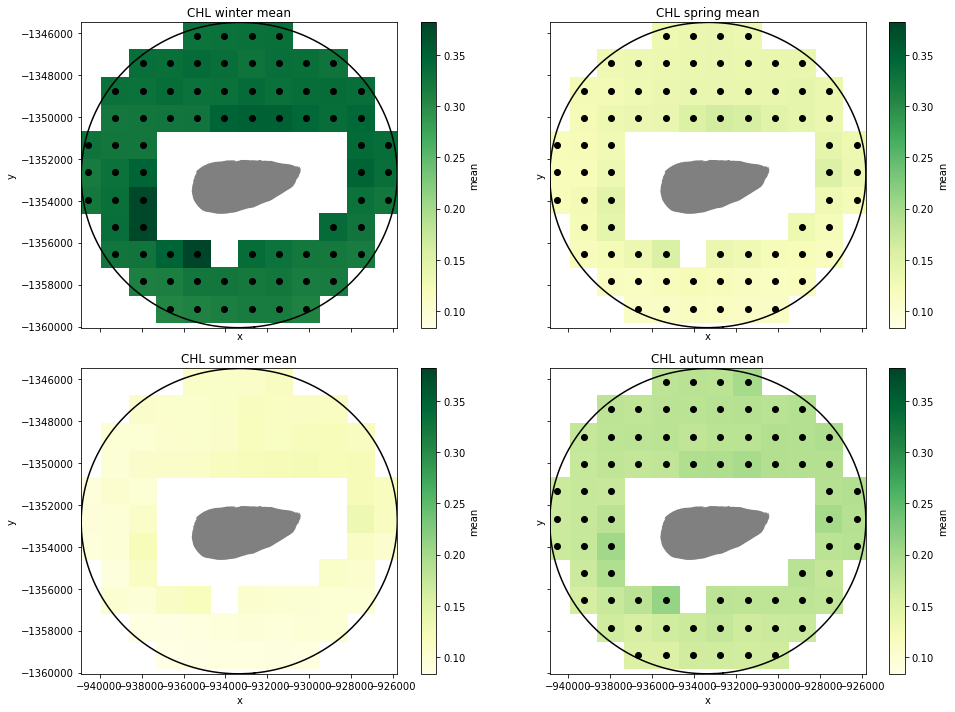

In [46]:

CI = shpf.Reader(AMP_path)
# the following codes obtain the minimum and maximum values in the time-series,
# and use them to set up the colormap
x=[winterCHLData['mean'].min().values,summerCHLData['mean'].min().values,
  springCHLData['mean'].min().values,autumnCHLData['mean'].min().values]
minV = min(x)
x=[winterCHLData['mean'].max().values,summerCHLData['mean'].max().values,
  springCHLData['mean'].max().values,autumnCHLData['mean'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

# four subplots
f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(14,10))
# winter
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,0])

winterCHLData['mean'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('CHL winter mean')

tempDF = winterCHLDF[winterCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

axes[0,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')
# spring
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,1])
springCHLData['mean'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('CHL spring mean')

tempDF = springCHLDF[springCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

axes[0,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
# summer    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,0])
summerCHLData['mean'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('CHL summer mean')

tempDF = summerCHLDF[summerCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

axes[1,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
# autumn    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,1])
autumnCHLData['mean'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('CHL autumn mean')

tempDF = autumnCHLDF[autumnCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')

for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    axes[1,1].plot(x, y, 'k')

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

**A conveinent function for calculating CHL monthly statistics**

In [47]:
def monthDF(month):
    meanList = []
    stdList = []
    countList = []
    freqList = []
    idList = []
    tempDF = pd.DataFrame()
    for col in chlDF.columns:
        if col.isdigit():
            nuData = chlDF.index.size - np.isnan(chlDF[col]).sum()
            if nuData > 0:            
                x = chlDF[col].groupby(chlDF['month']) # groupby month
                xDF = x.describe() # a DataFrame containing the results of the groupby operation
                mean = xDF.loc[month]['mean']
                std = xDF.loc[month]['std']
                count = xDF.loc[month]['count']
                freq = xDF.loc[month]['count'] / (chlDF['month']==month).sum() 

                idList.append(col)

                meanList.append(mean)
                stdList.append(std)
                countList.append(count)
                freqList.append(freq)
    tempDF['id'] = idList
    tempDF['mean'] = meanList
    tempDF['std'] = stdList
    tempDF['count'] = countList
    tempDF['freq'] = freqList
    tempDF.set_index('id',inplace=True)
    return tempDF


    

**calculate monthly statistics for each pixel**

In [48]:
JanCHLDF = monthDF('01')
FebCHLDF = monthDF('02')
MarCHLDF = monthDF('03')
AprCHLDF = monthDF('04')
MayCHLDF = monthDF('05')
JunCHLDF = monthDF('06')
JulCHLDF = monthDF('07')
AugCHLDF = monthDF('08')
SepCHLDF = monthDF('09')
OctCHLDF = monthDF('10')
NovCHLDF = monthDF('11')
DecCHLDF = monthDF('12')
             

        

**add x and y columns**

In [49]:
xList = []
yList = []
for id in JanCHLDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
JanCHLDF['x'] = xList
JanCHLDF['y'] = yList
FebCHLDF['x'] = xList
FebCHLDF['y'] = yList
MarCHLDF['x'] = xList
MarCHLDF['y'] = yList
AprCHLDF['x'] = xList
AprCHLDF['y'] = yList
MayCHLDF['x'] = xList
MayCHLDF['y'] = yList
JunCHLDF['x'] = xList
JunCHLDF['y'] = yList
JulCHLDF['x'] = xList
JulCHLDF['y'] = yList
AugCHLDF['x'] = xList
AugCHLDF['y'] = yList
SepCHLDF['x'] = xList
SepCHLDF['y'] = yList
OctCHLDF['x'] = xList
OctCHLDF['y'] = yList
NovCHLDF['x'] = xList
NovCHLDF['y'] = yList
DecCHLDF['x'] = xList
DecCHLDF['y'] = yList



**convert to xarray datasets**

In [50]:
JanCHLDF1 = JanCHLDF.copy()
JanCHLDF1.set_index(['y','x'],inplace=True)
JanCHLData = xr.Dataset.from_dataframe(JanCHLDF1)
JanCHLData.attrs['crs']='EPSG:3577'

FebCHLDF1 = FebCHLDF.copy()
FebCHLDF1.set_index(['y','x'],inplace=True)
FebCHLData = xr.Dataset.from_dataframe(FebCHLDF1)
FebCHLData.attrs['crs']='EPSG:3577'

MarCHLDF1 = MarCHLDF.copy()
MarCHLDF1.set_index(['y','x'],inplace=True)
MarCHLData = xr.Dataset.from_dataframe(MarCHLDF1)
MarCHLData.attrs['crs']='EPSG:3577'

AprCHLDF1 = AprCHLDF.copy()
AprCHLDF1.set_index(['y','x'],inplace=True)
AprCHLData = xr.Dataset.from_dataframe(AprCHLDF1)
AprCHLData.attrs['crs']='EPSG:3577'

MayCHLDF1 = MayCHLDF.copy()
MayCHLDF1.set_index(['y','x'],inplace=True)
MayCHLData = xr.Dataset.from_dataframe(MayCHLDF1)
MayCHLData.attrs['crs']='EPSG:3577'

JunCHLDF1 = JunCHLDF.copy()
JunCHLDF1.set_index(['y','x'],inplace=True)
JunCHLData = xr.Dataset.from_dataframe(JunCHLDF1)
JunCHLData.attrs['crs']='EPSG:3577'

JulCHLDF1 = JulCHLDF.copy()
JulCHLDF1.set_index(['y','x'],inplace=True)
JulCHLData = xr.Dataset.from_dataframe(JulCHLDF1)
JulCHLData.attrs['crs']='EPSG:3577'

AugCHLDF1 = AugCHLDF.copy()
AugCHLDF1.set_index(['y','x'],inplace=True)
AugCHLData = xr.Dataset.from_dataframe(AugCHLDF1)
AugCHLData.attrs['crs']='EPSG:3577'

SepCHLDF1 = SepCHLDF.copy()
SepCHLDF1.set_index(['y','x'],inplace=True)
SepCHLData = xr.Dataset.from_dataframe(SepCHLDF1)
SepCHLData.attrs['crs']='EPSG:3577'

OctCHLDF1 = OctCHLDF.copy()
OctCHLDF1.set_index(['y','x'],inplace=True)
OctCHLData = xr.Dataset.from_dataframe(OctCHLDF1)
OctCHLData.attrs['crs']='EPSG:3577'

NovCHLDF1 = NovCHLDF.copy()
NovCHLDF1.set_index(['y','x'],inplace=True)
NovCHLData = xr.Dataset.from_dataframe(NovCHLDF1)
NovCHLData.attrs['crs']='EPSG:3577'

DecCHLDF1 = DecCHLDF.copy()
DecCHLDF1.set_index(['y','x'],inplace=True)
DecCHLData = xr.Dataset.from_dataframe(DecCHLDF1)
DecCHLData.attrs['crs']='EPSG:3577'

**display spatial distributions of CHL monthly mean; the black dots indicate observation frequency greater than 30%**

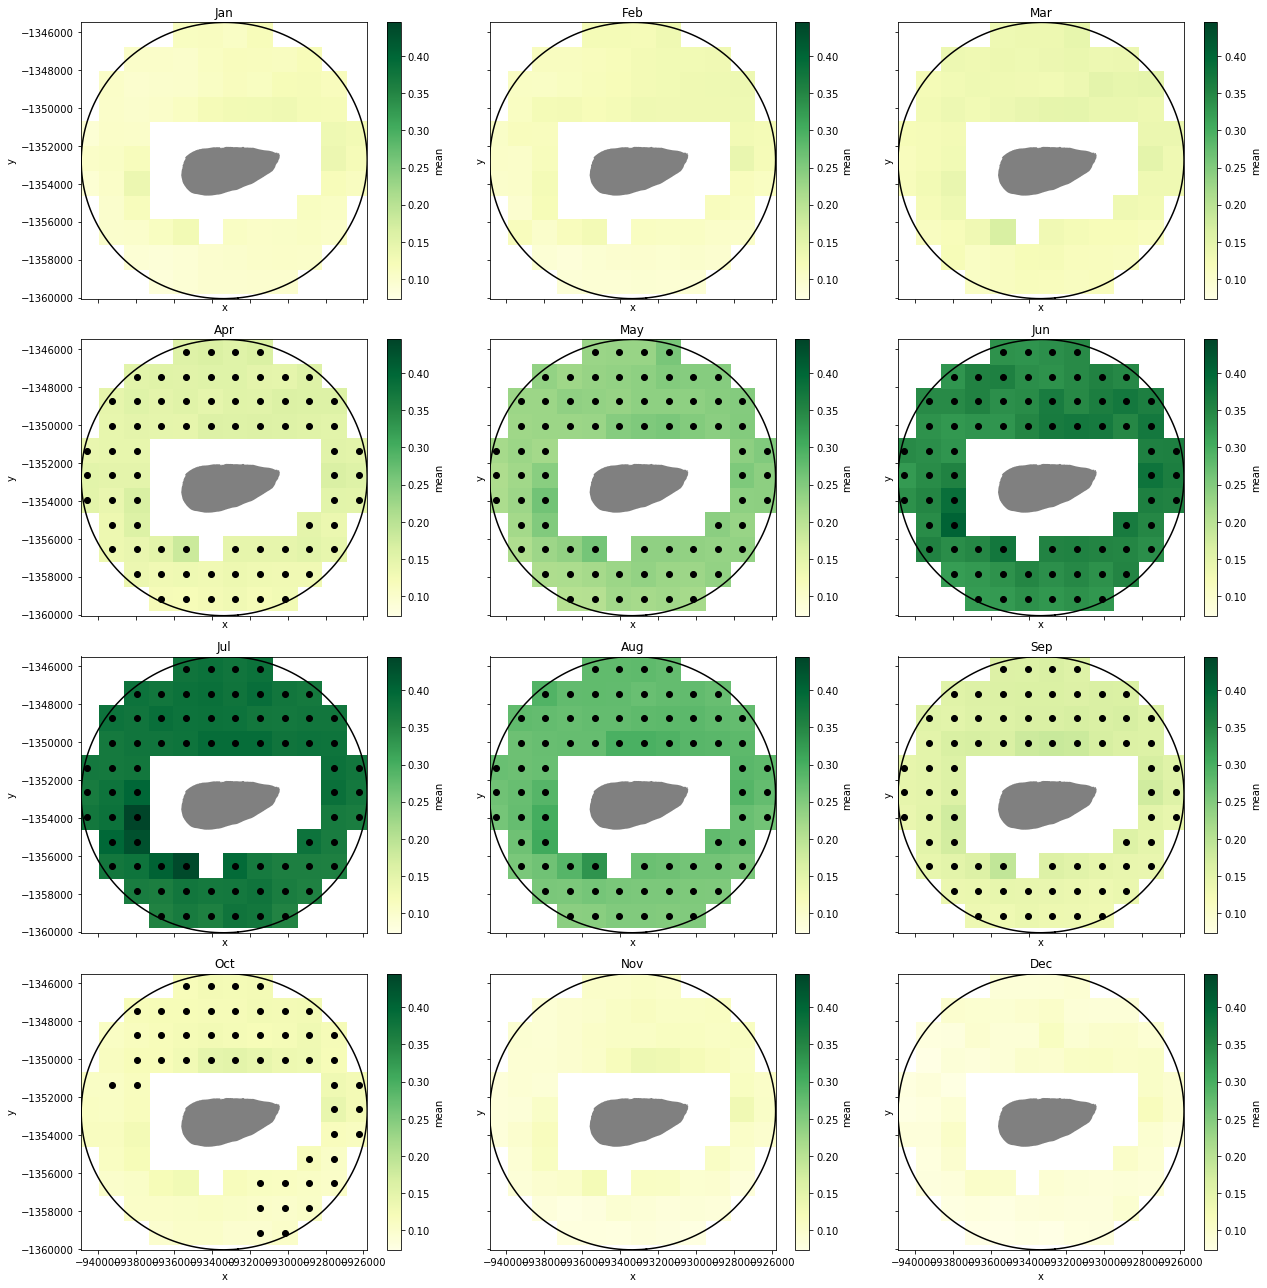

In [51]:
CI = shpf.Reader(AMP_path)

x=[JanCHLData['mean'].min().values,FebCHLData['mean'].min().values,
  MarCHLData['mean'].min().values,AprCHLData['mean'].min().values,
  MayCHLData['mean'].min().values,JunCHLData['mean'].min().values,
  JulCHLData['mean'].min().values,AugCHLData['mean'].min().values,
  SepCHLData['mean'].min().values,OctCHLData['mean'].min().values,
  NovCHLData['mean'].min().values,DecCHLData['mean'].min().values]
minV = min(x)
x=[JanCHLData['mean'].max().values,FebCHLData['mean'].max().values,
  MarCHLData['mean'].max().values,AprCHLData['mean'].max().values,
  MayCHLData['mean'].max().values,JunCHLData['mean'].max().values,
  JulCHLData['mean'].max().values,AugCHLData['mean'].max().values,
  SepCHLData['mean'].max().values,OctCHLData['mean'].max().values,
  NovCHLData['mean'].max().values,DecCHLData['mean'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

# 12 subplots, four rows, 3 columns, share x and y    
f, axes = plt.subplots(4,3,sharex='all',sharey='all',figsize=(18,18))
#Jan
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,0])
JanCHLData['mean'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('Jan')
tempDF = JanCHLDF[JanCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[0,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')
#Feb
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,1])
FebCHLData['mean'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('Feb')
tempDF = FebCHLDF[FebCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[0,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
#Mar
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,2])
MarCHLData['mean'].plot(cmap=colormap,ax=axes[0,2],vmin=minV,vmax=maxV)
axes[0,2].set_title('Mar')
tempDF = MarCHLDF[MarCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[0,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,2].plot(x, y, 'k')
#Apr    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,0])
AprCHLData['mean'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('Apr')
tempDF = AprCHLDF[AprCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
#May
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,1])
MayCHLData['mean'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('May')
tempDF = MayCHLDF[MayCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,1].plot(x, y, 'k')
#Jun
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,2])
JunCHLData['mean'].plot(cmap=colormap,ax=axes[1,2],vmin=minV,vmax=maxV)
axes[1,2].set_title('Jun')
tempDF = JunCHLDF[JunCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,2].plot(x, y, 'k')
#Jul
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,0])
JulCHLData['mean'].plot(cmap=colormap,ax=axes[2,0],vmin=minV,vmax=maxV)
axes[2,0].set_title('Jul')
tempDF = JulCHLDF[JulCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[2,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,0].plot(x, y, 'k')
#Aug   
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,1])
AugCHLData['mean'].plot(cmap=colormap,ax=axes[2,1],vmin=minV,vmax=maxV)
axes[2,1].set_title('Aug')
tempDF = AugCHLDF[AugCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[2,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,1].plot(x, y, 'k')
#Sep
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,2])
SepCHLData['mean'].plot(cmap=colormap,ax=axes[2,2],vmin=minV,vmax=maxV)
axes[2,2].set_title('Sep')
tempDF = SepCHLDF[SepCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[2,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,2].plot(x, y, 'k')
#Oct
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,0])
OctCHLData['mean'].plot(cmap=colormap,ax=axes[3,0],vmin=minV,vmax=maxV)
axes[3,0].set_title('Oct')
tempDF = OctCHLDF[OctCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[3,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,0].plot(x, y, 'k')
#Nov
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,1])
NovCHLData['mean'].plot(cmap=colormap,ax=axes[3,1],vmin=minV,vmax=maxV)
axes[3,1].set_title('Nov')
tempDF = NovCHLDF[NovCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[3,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,1].plot(x, y, 'k')
#Dec
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,2])
DecCHLData['mean'].plot(cmap=colormap,ax=axes[3,2],vmin=minV,vmax=maxV)
axes[3,2].set_title('Dec')
tempDF = DecCHLDF[DecCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[3,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,2].plot(x, y, 'k')
    
xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

### Calculate the annual trends of seasons and months

**function for generating annual time-series of seasonal mean for each pixel**

In [52]:
def yearseasonCHL(season):
    tempDF = pd.DataFrame()
    for col in chlDF.columns:
        
        if col.isdigit():
            
            nuData = chlDF.index.size - np.isnan(chlDF[col]).sum()
            if nuData > 0:
                x = chlDF[chlDF['season'] == season]
                y = x[col].groupby(x['year'])
                
                xDF = y.describe() # a DataFrame containing the results of the groupby operation
                tempDF[col] = xDF['mean'] # only interest in the mean statists
                
    return tempDF

In [53]:
yearwinterDF = yearseasonCHL('winter')
yearspringDF = yearseasonCHL('spring')
yearsummerDF = yearseasonCHL('summer')
yearautumnDF = yearseasonCHL('autumn')

In [54]:
# years 2002 and 2019 do not contain a full summer season
# summer months 12, 1 and 2 expand two years, this is another issue
yearsummerDF1 = yearsummerDF.loc['2003':'2018']

**function for calculating trends of annual time-series of seasonal mean for each pixel with some valid data**

In [55]:
def yearseasonTrend(yearseasonDF,season):
    ind = np.arange(1,yearseasonDF.index.size+1,1)
    yearseasonDF['ind'] = ind
    yearseasonRateDF = pd.DataFrame()
    idList = []
    rateList = []
    pValueList = []
    for col in yearseasonDF.columns:
        
        if col.isdigit():
            idList.append(col)
            x = yearseasonDF.index.size - np.isnan(yearseasonDF[col]).sum()
            f = x/yearseasonDF.index.size
            # only calculate trend if having more than 50% of valid data
            if f > 0.5:               
                # note the Q() function for the proper handling of the number as a column name
                formula = 'Q("' + col + '")' + ' ~ ind'

                fit = sm.ols(formula=formula, data=yearseasonDF, missing='drop').fit()

                predict = fit.predict(yearseasonDF)
                yearseasonDF['fitted'] = predict
                rate = round(fit.params[1],3)
                pValue = round(fit.pvalues[1],2)
            else:
                rate = np.nan
                pValue = np.nan

            rateList.append(rate)
            pValueList.append(pValue)
        else:
            break
    yearseasonRateDF['id'] = idList
    yearseasonRateDF['rate'] = rateList
    yearseasonRateDF['pValue'] = pValueList

    countList = []
    freqList = []
    tempDF = chlDF[chlDF['season'] == season]
    
    for col in yearseasonDF.columns:
        
        if col.isdigit():        
            x = tempDF.index.size - np.isnan(tempDF[col]).sum()
            
                      
            f = x/tempDF.index.size
           
            countList.append(x)
            freqList.append(f)
        else:
            break
    yearseasonRateDF['count'] = countList
    yearseasonRateDF['frequency'] = freqList
    yearseasonRateDF.set_index("id",inplace=True)
    
    return yearseasonRateDF

In [56]:
yearwinterRateDF = yearseasonTrend(yearwinterDF,'winter')
yearspringRateDF = yearseasonTrend(yearspringDF,'spring')
yearsummerRateDF = yearseasonTrend(yearsummerDF1,'summer')
yearautumnRateDF = yearseasonTrend(yearautumnDF,'autumn')

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**add x and y columns**

In [57]:
xList = []
yList = []
for id in yearsummerRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearsummerRateDF['x'] = xList
yearsummerRateDF['y'] = yList
yearspringRateDF['x'] = xList
yearspringRateDF['y'] = yList
yearautumnRateDF['x'] = xList
yearautumnRateDF['y'] = yList
yearwinterRateDF['x'] = xList
yearwinterRateDF['y'] = yList


**convert to xarray datasets**

In [58]:
yearsummerRateDF1 = yearsummerRateDF.copy()
yearsummerRateDF1.set_index(['y','x'],inplace=True)
yearsummerRateData = xr.Dataset.from_dataframe(yearsummerRateDF1)
yearsummerRateData.attrs['crs']='EPSG:3577'

yearspringRateDF1 = yearspringRateDF.copy()
yearspringRateDF1.set_index(['y','x'],inplace=True)
yearspringRateData = xr.Dataset.from_dataframe(yearspringRateDF1)
yearspringRateData.attrs['crs']='EPSG:3577'

yearautumnRateDF1 = yearautumnRateDF.copy()
yearautumnRateDF1.set_index(['y','x'],inplace=True)
yearautumnRateData = xr.Dataset.from_dataframe(yearautumnRateDF1)
yearautumnRateData.attrs['crs']='EPSG:3577'

yearwinterRateDF1 = yearwinterRateDF.copy()
yearwinterRateDF1.set_index(['y','x'],inplace=True)
yearwinterRateData = xr.Dataset.from_dataframe(yearwinterRateDF1)
yearwinterRateData.attrs['crs']='EPSG:3577'

**display spatial patterns of annual trends of seasonal means; the black dots indicate statistical signficance at 90% confidence level**

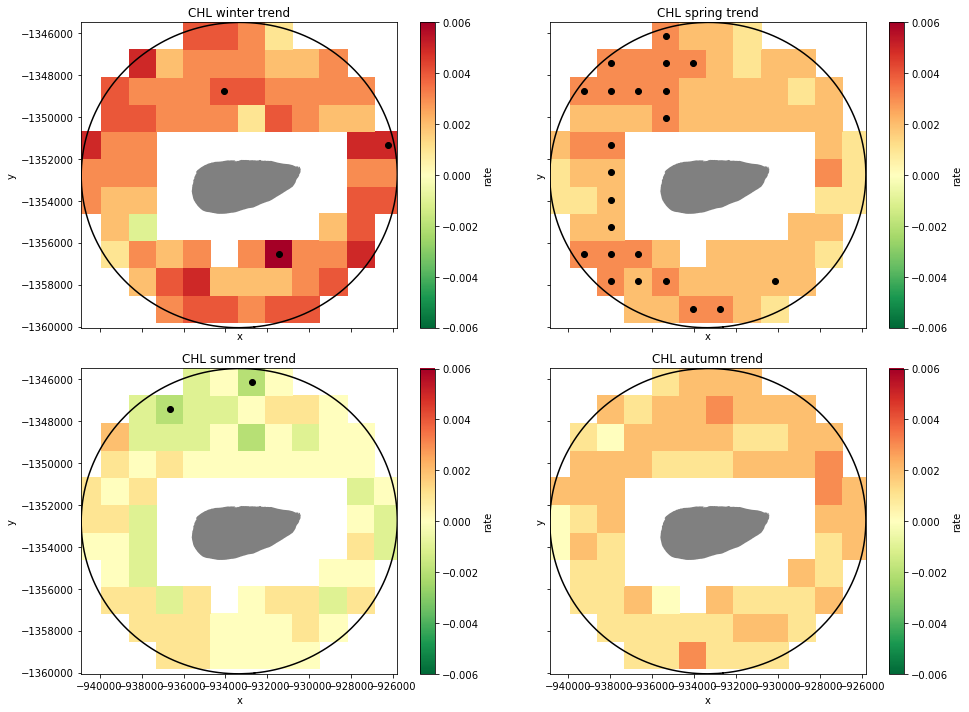

In [59]:
CI = shpf.Reader(AMP_path)

x=[yearwinterRateData['rate'].min().values,yearsummerRateData['rate'].min().values,
  yearspringRateData['rate'].min().values,yearautumnRateData['rate'].min().values]
minV = min(x)
x=[yearwinterRateData['rate'].max().values,yearsummerRateData['rate'].max().values,
  yearspringRateData['rate'].max().values,yearautumnRateData['rate'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)


f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(14,10))
#winter
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,0])

yearwinterRateData['rate'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('CHL winter trend')

tempDF = yearwinterRateDF[yearwinterRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[0,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')
#spring
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,1])
yearspringRateData['rate'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('CHL spring trend')

tempDF = yearspringRateDF[yearspringRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[0,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
#summer    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,0])
yearsummerRateData['rate'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('CHL summer trend')

tempDF = yearsummerRateDF[yearsummerRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[1,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
#autumn    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,1])
yearautumnRateData['rate'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('CHL autumn trend')

tempDF = yearautumnRateDF[yearautumnRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')

for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    axes[1,1].plot(x, y, 'k')

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

**function for generating annual time-series of monthly mean for each pixel with some valid data**

In [60]:
def yearmonthCHL(month):
    tempDF = pd.DataFrame()
    for col in chlDF.columns:
        
        if col.isdigit():
            
            nuData = chlDF.index.size - np.isnan(chlDF[col]).sum()
            if nuData > 0:
                x = chlDF[chlDF['month'] == month]
                y = x[col].groupby(x['year'])
                
                xDF = y.describe() # a DataFrame containing the results of the groupby operation
                tempDF[col] = xDF['mean'] # only interest in the mean statists
                
    return tempDF

**function for calculating trends of annual time-series of monthly mean for each pixel with some valid data**

In [61]:
def yearmonthTrend(yearmonthDF,month):
    ind = np.arange(1,yearmonthDF.index.size+1,1)
    yearmonthDF['ind'] = ind
    yearmonthRateDF = pd.DataFrame()
    idList = []
    rateList = []
    pValueList = []
    for col in yearmonthDF.columns:
        
        if col.isdigit():
            idList.append(col)
            x = yearmonthDF.index.size - np.isnan(yearmonthDF[col]).sum()
            f = x/yearmonthDF.index.size
            # only calculate trend when the observation frequency is greater than 50%
            if f > 0.5:
                
                # note the Q() function for the proper handling of the number as a column name
                formula = 'Q("' + col + '")' + ' ~ ind'

                fit = sm.ols(formula=formula, data=yearmonthDF, missing='drop').fit()

                predict = fit.predict(yearmonthDF)
                yearmonthDF['fitted'] = predict
                rate = round(fit.params[1],3)
                pValue = round(fit.pvalues[1],2)
            else:
                rate = np.nan
                pValue = np.nan

            rateList.append(rate)
            pValueList.append(pValue)
        else:
            break
    yearmonthRateDF['id'] = idList
    yearmonthRateDF['rate'] = rateList
    yearmonthRateDF['pValue'] = pValueList

    countList = []
    freqList = []
    tempDF = chlDF[chlDF['month'] == month]
    
    for col in yearmonthDF.columns:
        
        if col.isdigit():        
            x = tempDF.index.size - np.isnan(tempDF[col]).sum()
            
                      
            f = x/tempDF.index.size
           
            countList.append(x)
            freqList.append(f)
        else:
            break
    yearmonthRateDF['count'] = countList
    yearmonthRateDF['frequency'] = freqList
    yearmonthRateDF.set_index("id",inplace=True)
    
    return yearmonthRateDF

**calculate annual time-series of monthly means and their trends**

In [62]:
yearJanDF = yearmonthCHL('01')
yearJanRateDF = yearmonthTrend(yearJanDF,'01')
yearFebDF = yearmonthCHL('02')
yearFebRateDF = yearmonthTrend(yearFebDF,'02')
yearMarDF = yearmonthCHL('03')
yearMarRateDF = yearmonthTrend(yearMarDF,'03')
yearAprDF = yearmonthCHL('04')
yearAprRateDF = yearmonthTrend(yearAprDF,'04')
yearMayDF = yearmonthCHL('05')
yearMayRateDF = yearmonthTrend(yearMayDF,'05')
yearJunDF = yearmonthCHL('06')
yearJunRateDF = yearmonthTrend(yearJunDF,'06')
yearJulDF = yearmonthCHL('07')
yearJulRateDF = yearmonthTrend(yearJulDF,'07')
yearAugDF = yearmonthCHL('08')
yearAugRateDF = yearmonthTrend(yearAugDF,'08')
yearSepDF = yearmonthCHL('09')
yearSepRateDF = yearmonthTrend(yearSepDF,'09')
yearOctDF = yearmonthCHL('10')
yearOctRateDF = yearmonthTrend(yearOctDF,'10')
yearNovDF = yearmonthCHL('11')
yearNovRateDF = yearmonthTrend(yearNovDF,'11')
yearDecDF = yearmonthCHL('12')
yearDecRateDF = yearmonthTrend(yearDecDF,'12')

**add x and y columns**

In [63]:
xList = []
yList = []
for id in yearJanRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearJanRateDF['x'] = xList
yearJanRateDF['y'] = yList
yearFebRateDF['x'] = xList
yearFebRateDF['y'] = yList
yearMarRateDF['x'] = xList
yearMarRateDF['y'] = yList
yearAprRateDF['x'] = xList
yearAprRateDF['y'] = yList
yearMayRateDF['x'] = xList
yearMayRateDF['y'] = yList
yearJunRateDF['x'] = xList
yearJunRateDF['y'] = yList
yearJulRateDF['x'] = xList
yearJulRateDF['y'] = yList
yearAugRateDF['x'] = xList
yearAugRateDF['y'] = yList
yearSepRateDF['x'] = xList
yearSepRateDF['y'] = yList
yearOctRateDF['x'] = xList
yearOctRateDF['y'] = yList
yearNovRateDF['x'] = xList
yearNovRateDF['y'] = yList
yearDecRateDF['x'] = xList
yearDecRateDF['y'] = yList


**convert to xarray datasets**

In [64]:
yearJanRateDF1 = yearJanRateDF.copy()
yearJanRateDF1.set_index(['y','x'],inplace=True)
yearJanRateData = xr.Dataset.from_dataframe(yearJanRateDF1)
yearJanRateData.attrs['crs']='EPSG:3577'

yearFebRateDF1 = yearFebRateDF.copy()
yearFebRateDF1.set_index(['y','x'],inplace=True)
yearFebRateData = xr.Dataset.from_dataframe(yearFebRateDF1)
yearFebRateData.attrs['crs']='EPSG:3577'

yearMarRateDF1 = yearMarRateDF.copy()
yearMarRateDF1.set_index(['y','x'],inplace=True)
yearMarRateData = xr.Dataset.from_dataframe(yearMarRateDF1)
yearMarRateData.attrs['crs']='EPSG:3577'

yearAprRateDF1 = yearAprRateDF.copy()
yearAprRateDF1.set_index(['y','x'],inplace=True)
yearAprRateData = xr.Dataset.from_dataframe(yearAprRateDF1)
yearAprRateData.attrs['crs']='EPSG:3577'

yearMayRateDF1 = yearMayRateDF.copy()
yearMayRateDF1.set_index(['y','x'],inplace=True)
yearMayRateData = xr.Dataset.from_dataframe(yearMayRateDF1)
yearMayRateData.attrs['crs']='EPSG:3577'

yearJunRateDF1 = yearJunRateDF.copy()
yearJunRateDF1.set_index(['y','x'],inplace=True)
yearJunRateData = xr.Dataset.from_dataframe(yearJunRateDF1)
yearJunRateData.attrs['crs']='EPSG:3577'

yearJulRateDF1 = yearJulRateDF.copy()
yearJulRateDF1.set_index(['y','x'],inplace=True)
yearJulRateData = xr.Dataset.from_dataframe(yearJulRateDF1)
yearJulRateData.attrs['crs']='EPSG:3577'

yearAugRateDF1 = yearAugRateDF.copy()
yearAugRateDF1.set_index(['y','x'],inplace=True)
yearAugRateData = xr.Dataset.from_dataframe(yearAugRateDF1)
yearAugRateData.attrs['crs']='EPSG:3577'

yearSepRateDF1 = yearSepRateDF.copy()
yearSepRateDF1.set_index(['y','x'],inplace=True)
yearSepRateData = xr.Dataset.from_dataframe(yearSepRateDF1)
yearSepRateData.attrs['crs']='EPSG:3577'

yearOctRateDF1 = yearOctRateDF.copy()
yearOctRateDF1.set_index(['y','x'],inplace=True)
yearOctRateData = xr.Dataset.from_dataframe(yearOctRateDF1)
yearOctRateData.attrs['crs']='EPSG:3577'

yearNovRateDF1 = yearNovRateDF.copy()
yearNovRateDF1.set_index(['y','x'],inplace=True)
yearNovRateData = xr.Dataset.from_dataframe(yearNovRateDF1)
yearNovRateData.attrs['crs']='EPSG:3577'

yearDecRateDF1 = yearDecRateDF.copy()
yearDecRateDF1.set_index(['y','x'],inplace=True)
yearDecRateData = xr.Dataset.from_dataframe(yearDecRateDF1)
yearDecRateData.attrs['crs']='EPSG:3577'

**display spatial patterns of annual trends of monthly means; the black dots indicate statistical signficance at 90% confidence level**

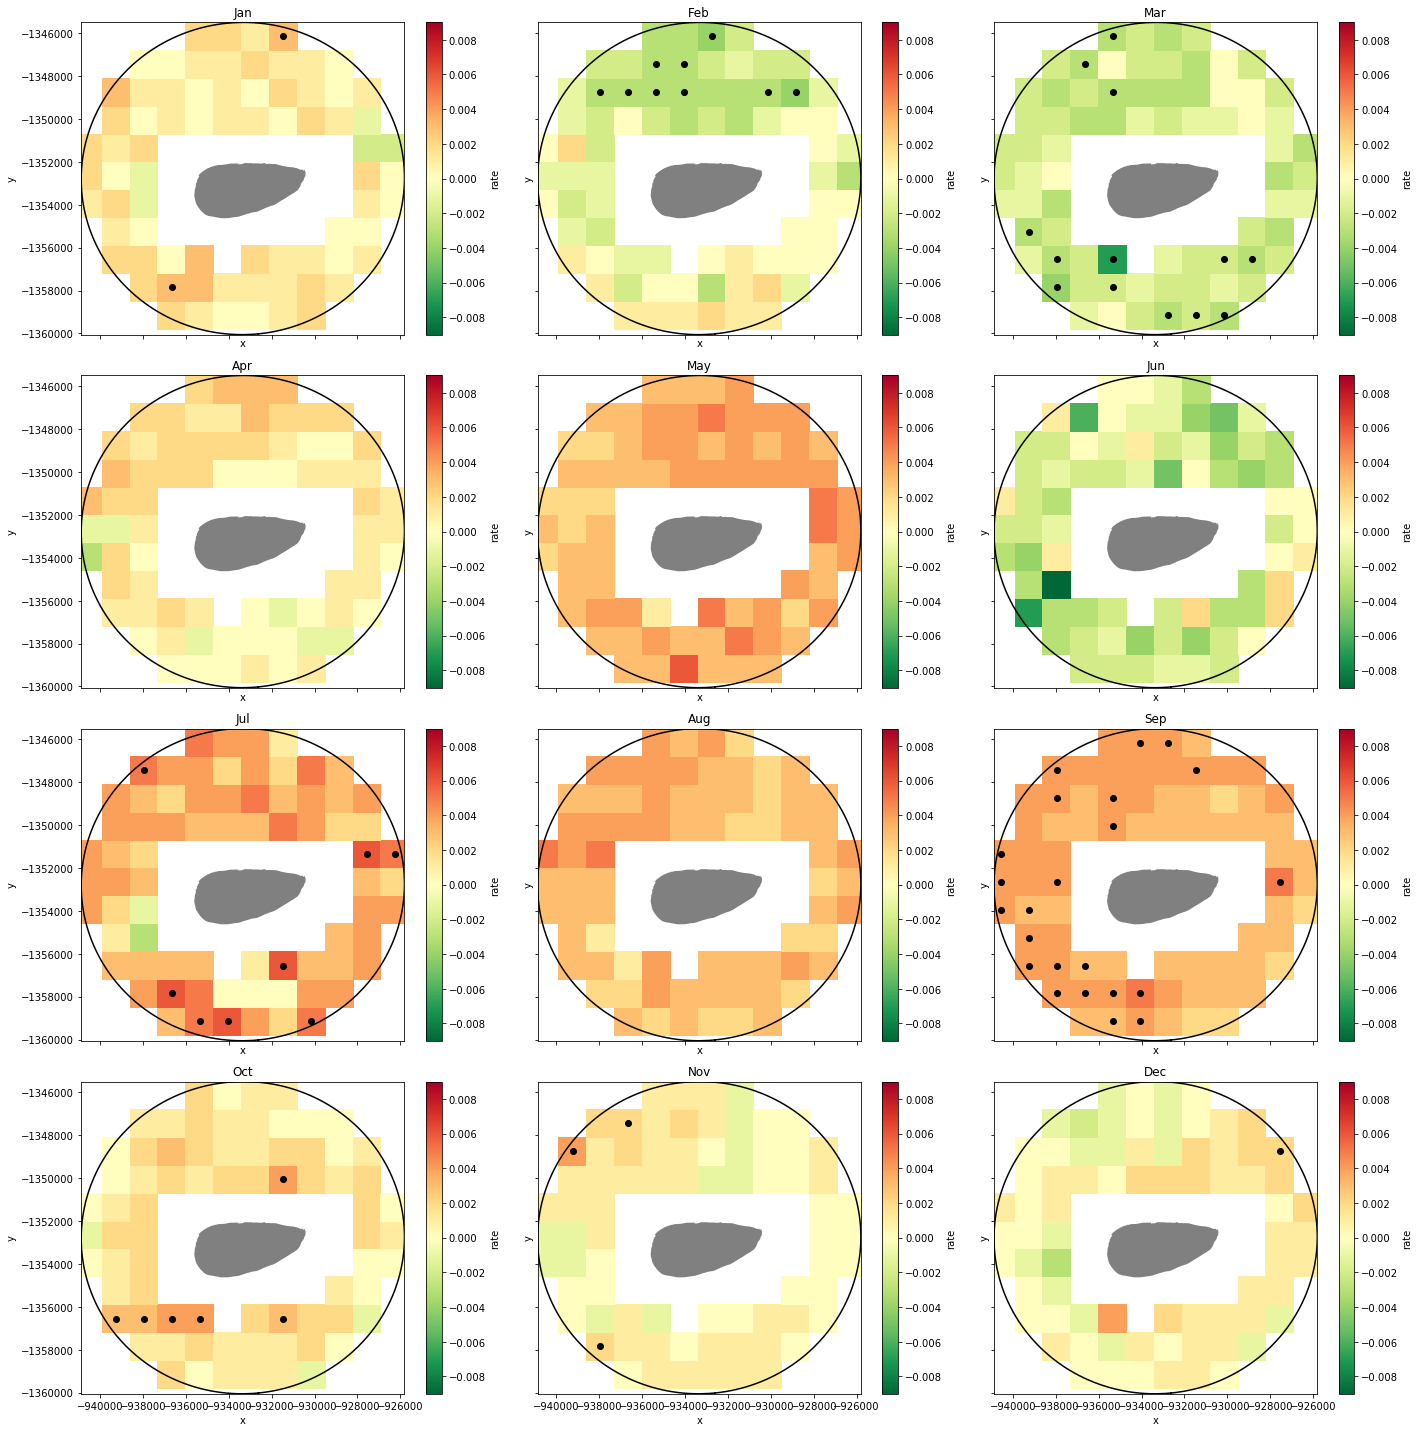

In [65]:
CI = shpf.Reader(AMP_path)

x=[yearJanRateData['rate'].min().values,yearFebRateData['rate'].min().values,
  yearMarRateData['rate'].min().values,yearAprRateData['rate'].min().values,
  yearMayRateData['rate'].min().values,yearJunRateData['rate'].min().values,
  yearJulRateData['rate'].min().values,yearAugRateData['rate'].min().values,
  yearSepRateData['rate'].min().values,yearOctRateData['rate'].min().values,
  yearNovRateData['rate'].min().values,yearDecRateData['rate'].min().values]
minV = min(x)
x=[yearJanRateData['rate'].max().values,yearFebRateData['rate'].max().values,
  yearMarRateData['rate'].max().values,yearAprRateData['rate'].max().values,
  yearMayRateData['rate'].max().values,yearJunRateData['rate'].max().values,
  yearJulRateData['rate'].max().values,yearAugRateData['rate'].max().values,
  yearSepRateData['rate'].max().values,yearOctRateData['rate'].max().values,
  yearNovRateData['rate'].max().values,yearDecRateData['rate'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

    
f, axes = plt.subplots(4,3,sharex='all',sharey='all',figsize=(20,20))
#Jan
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,0])
yearJanRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('Jan')
tempDF = yearJanRateDF[yearJanRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')
#Feb
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,1])
yearFebRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('Feb')
tempDF = yearFebRateDF[yearFebRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
#Mar
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,2])
yearMarRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,2],vmin=minV,vmax=maxV)
axes[0,2].set_title('Mar')
tempDF = yearMarRateDF[yearMarRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,2].plot(x, y, 'k')
#Apr    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,0])
yearAprRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('Apr')
tempDF = yearAprRateDF[yearAprRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
#May
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,1])
yearMayRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('May')
tempDF = yearMayRateDF[yearMayRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,1].plot(x, y, 'k')
#Jun
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,2])
yearJunRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,2],vmin=minV,vmax=maxV)
axes[1,2].set_title('Jun')
tempDF = yearJunRateDF[yearJunRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,2].plot(x, y, 'k')
#Jul
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,0])
yearJulRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,0],vmin=minV,vmax=maxV)
axes[2,0].set_title('Jul')
tempDF = yearJulRateDF[yearJulRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,0].plot(x, y, 'k')
#Aug    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,1])
yearAugRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,1],vmin=minV,vmax=maxV)
axes[2,1].set_title('Aug')
tempDF = yearAugRateDF[yearAugRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,1].plot(x, y, 'k')
#Sep
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,2])
yearSepRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,2],vmin=minV,vmax=maxV)
axes[2,2].set_title('Sep')
tempDF = yearSepRateDF[yearSepRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,2].plot(x, y, 'k')
#Oct
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,0])
yearOctRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,0],vmin=minV,vmax=maxV)
axes[3,0].set_title('Oct')
tempDF = yearOctRateDF[yearOctRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,0].plot(x, y, 'k')
#Nov
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,1])
yearNovRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,1],vmin=minV,vmax=maxV)
axes[3,1].set_title('Nov')
tempDF = yearNovRateDF[yearNovRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,1].plot(x, y, 'k')
#Dec
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,2])
yearDecRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,2],vmin=minV,vmax=maxV)
axes[3,2].set_title('Dec')
tempDF = yearDecRateDF[yearDecRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,2].plot(x, y, 'k')
    
xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

## identify locations of potential primary productivity hotspot

**define a function for the calculation of the likelihood of productivity hotspot**

In [66]:
def hotspot(statsDF,dataDF):
    ## high productivity threshold is (spatial) mean + 2 * (spatial) std
    # statsDF is a dataframe containing time-series statistics of each cell
    # dataDF is a dataframe containing time-series data for each cell
    a = statsDF['mean'].mean() + 2 * statsDF['mean'].std()
    hotspotDF = pd.DataFrame()
    idList = []
    probList = []
    freqList = []
    for col in dataDF.columns:

        if col.isdigit():
            nuData = dataDF.index.size - np.isnan(dataDF[col]).sum()
            if nuData > 0:
                idList.append(col)
                # for each cell, calculate the hotspot probability which equals the freqency of high-productivity days out of the total observed days
                prob = (dataDF[col]>a).sum() / nuData 
                probList.append(prob)
                freq = nuData / dataDF.index.size
                freqList.append(freq)
        else:
            break
    hotspotDF['id'] = idList
    hotspotDF['prob'] = probList
    hotspotDF['freq'] = freqList
    hotspotDF.set_index('id',inplace=True)
    xList = []
    yList = []
    for id in hotspotDF.index:
        x = int(latlonDF.loc[id]['lon'])
        y = int(latlonDF.loc[id]['lat'])
        xList.append(x)
        yList.append(y)
    hotspotDF['x'] = xList
    hotspotDF['y'] = yList
    
    return hotspotDF


### identify the overall hotspot

Only those locations with the likelihood >= 0.75 are considered as the hotspots

In [67]:
overallhotspotDF = hotspot(overallDF,chlDF)

**convert to xarray dataset**

In [68]:
overallhotspotDF1 = overallhotspotDF.copy()
overallhotspotDF1.set_index(['y','x'],inplace=True)
overallhotspotData = xr.Dataset.from_dataframe(overallhotspotDF1)
overallhotspotData.attrs['crs']='EPSG:3577'

**display spatial distribution of the likelihood of overall productivity hotspot; the black dots indicate observation frequency greater than 30%**

<Figure size 720x576 with 0 Axes>

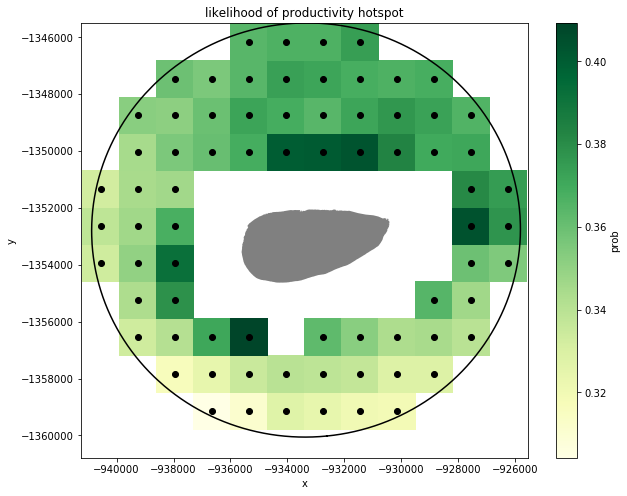

In [69]:
CI = shpf.Reader(AMP_path)

fig = plt.figure(figsize=(10,8))
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',figsize=(10,8))
overallhotspotData['prob'].plot(cmap='YlGn')
plt.title('likelihood of productivity hotspot')
plt.axis('equal')
tempDF = overallhotspotDF[overallhotspotDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


### identify seasonal hotspots

In [70]:
tempDF = chlDF[chlDF['season'] == 'winter']
winterhotspotDF = hotspot(winterCHLDF,tempDF)

tempDF = chlDF[chlDF['season'] == 'spring']
springhotspotDF = hotspot(springCHLDF,tempDF)

tempDF = chlDF[chlDF['season'] == 'summer']
summerhotspotDF = hotspot(summerCHLDF,tempDF)

tempDF = chlDF[chlDF['season'] == 'autumn']
autumnhotspotDF = hotspot(autumnCHLDF,tempDF)

**convert to xarray datasets**

In [71]:
winterhotspotDF1 = winterhotspotDF.copy()
winterhotspotDF1.set_index(['y','x'],inplace=True)
winterhotspotData = xr.Dataset.from_dataframe(winterhotspotDF1)
winterhotspotData.attrs['crs']='EPSG:3577'

springhotspotDF1 = springhotspotDF.copy()
springhotspotDF1.set_index(['y','x'],inplace=True)
springhotspotData = xr.Dataset.from_dataframe(springhotspotDF1)
springhotspotData.attrs['crs']='EPSG:3577'

summerhotspotDF1 = summerhotspotDF.copy()
summerhotspotDF1.set_index(['y','x'],inplace=True)
summerhotspotData = xr.Dataset.from_dataframe(summerhotspotDF1)
summerhotspotData.attrs['crs']='EPSG:3577'

autumnhotspotDF1 = autumnhotspotDF.copy()
autumnhotspotDF1.set_index(['y','x'],inplace=True)
autumnhotspotData = xr.Dataset.from_dataframe(autumnhotspotDF1)
autumnhotspotData.attrs['crs']='EPSG:3577'

**display spatial distributions of the likelihood of the seasonal hotspots; the black dots indicate the observation frequency greater than 30%**

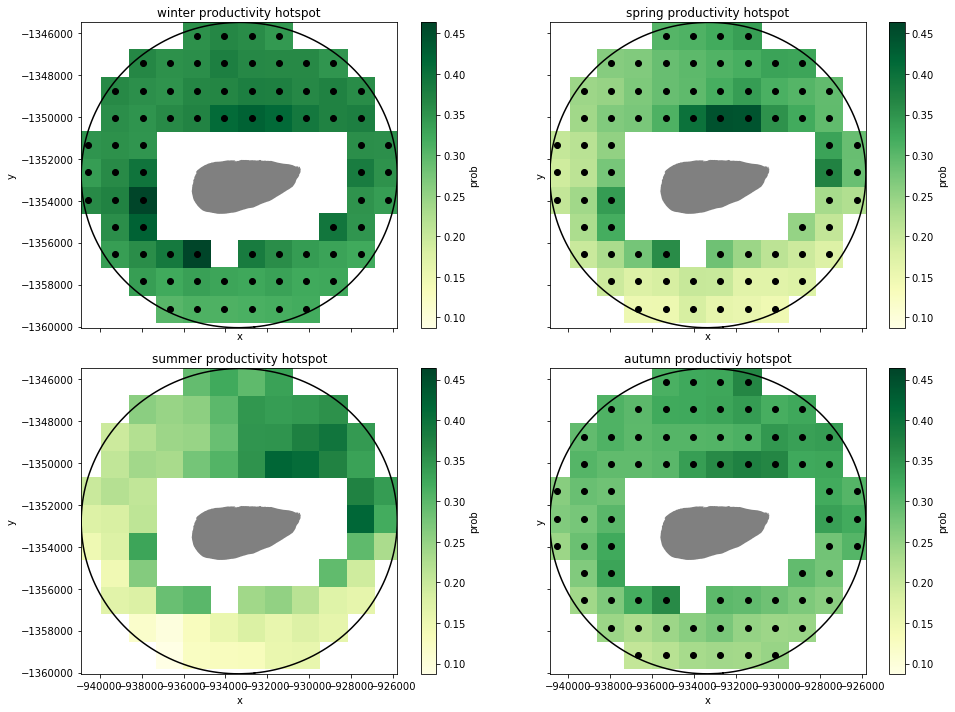

In [74]:
CI = shpf.Reader(AMP_path)

x=[winterhotspotData['prob'].min().values,summerhotspotData['prob'].min().values,
  springhotspotData['prob'].min().values,autumnhotspotData['prob'].min().values]
minV = min(x)
x=[winterhotspotData['prob'].max().values,summerhotspotData['prob'].max().values,
  springhotspotData['prob'].max().values,autumnhotspotData['prob'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)


f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(14,10))
#winter
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,0])

winterhotspotData['prob'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('winter productivity hotspot')

tempDF = winterhotspotDF[winterhotspotDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']

axes[0,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')
#spring
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,1])
springhotspotData['prob'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('spring productivity hotspot')

tempDF = springhotspotDF[springhotspotDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']

axes[0,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
#summer    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,0])
summerhotspotData['prob'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('summer productivity hotspot')

tempDF = summerhotspotDF[summerhotspotDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']

axes[1,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
#autumn    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,1])
autumnhotspotData['prob'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('autumn productiviy hotspot')

tempDF = autumnhotspotDF[autumnhotspotDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')

for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    axes[1,1].plot(x, y, 'k')

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

## Additional information
    
**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.
  
**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).
 
**Last modified:** April 2020
   
**Compatible datacube version:** 

In [73]:
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags

Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)